In [1]:
import numpy as np
from dataset.QM7XDataset import QM7XEmbedDataset
from pathlib import Path
import torch
import pickle
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


/home/n7student/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/n7student/.local/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


## Les données scattering et/ou contrastive

In [2]:
from get_X_y_train_test import get_X_y_train_test
X_train, X_test, y_train, y_test = get_X_y_train_test(avec_coef_contrastive=True)

## Regression multi Lin

In [ ]:
from models.regression_multi_lin import RegressionModel

X_train shape: torch.Size([5931, 706]), y_train shape: torch.Size([5931, 1])
X_test shape: torch.Size([660, 706]), y_test shape: torch.Size([660, 1])
Epoch 1/20, Loss: 4268.9087
Epoch 10/20, Loss: 4.3587
Epoch 20/20, Loss: 2.6885


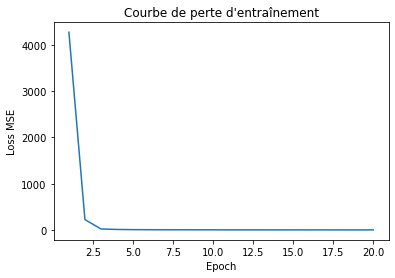

PyTorch RMSE: 1.9219, R2: 0.9755, MAE: 0.7483


In [7]:


# Données X, y: numpy arrays
# Exemple: X = np.array(...), y = np.array(...)

# Paramètres
batch_size = 32
lr = 1e-3
epochs = 20



# Conversion en tenseurs PyTorch
torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().unsqueeze(1)

print(f"X_train shape: {X_train_t.shape}, y_train shape: {y_train_t.shape}")
print(f"X_test shape: {X_test_t.shape}, y_test shape: {y_test_t.shape}")
# DataLoaders
dataset_train = TensorDataset(X_train_t, y_train_t)
dataset_test = TensorDataset(X_test_t, y_test_t)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size)

# Initialisation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X_train.shape[1]
q = 300
k = 3
model = RegressionModel(input_dim, q, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


# Entraînement avec suivi de la loss
history = []
for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    for xb, yb in loader_train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    history.append(avg_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# Plot de la loss d'entraînement
plt.figure()
plt.plot(range(1, epochs+1), history)
plt.xlabel('Epoch')
plt.ylabel('Loss MSE')
plt.title("Courbe de perte d'entraînement")
plt.show()

# Évaluation sur test
model.eval()
with torch.no_grad():
    preds_test = model(X_test_t.to(device)).cpu().squeeze().numpy()
rmse = mean_squared_error(y_test, preds_test)**0.5
mae = mean_absolute_error(y_test, preds_test)
r2 = r2_score(y_test, preds_test)
print(f"PyTorch RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")


## Regressor Stacking

In [8]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1) Définir les estimateurs sklearn-compatibles

# XGBoost
xgb_sk = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.1,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=2,
    random_state=42,
    verbosity=0
)

# LightGBM
lgb_sk = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=2,
    random_state=42
)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=2,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

# 2) Entraîner chaque modèle sur vos données
xgb_sk.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
lgb_sk.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
)
rf.fit(X_train, y_train)

# 3) Créer et entraîner le stacking
estimators = [
    ('xgb', xgb_sk),
    ('lgb', lgb_sk),
    ('rf', rf)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)

# 4) Évaluer
y_pred = stack.predict(X_test)
print(f"Stacking RMSE: {mean_squared_error(y_test, y_pred)**0.5:.4f}")
print(f"Stacking R²:   {r2_score(y_test, y_pred):.4f}")
print(f"Stacking MAE:  {mean_absolute_error(y_test, y_pred):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158801
[LightGBM] [Info] Number of data points in the train set: 5931, number of used features: 667
[LightGBM] [Info] Start training from score -77.923448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158801
[LightGBM] [Info] Number of data points in the train set: 5931, number of used features: 667
[LightGBM] [Info] Start training from score -77.923448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.w

Stacking RMSE: 0.3614
Stacking R²:   0.9991
Stacking MAE:  0.1736


/home/n7student/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
